[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/pixeltable/pixeltable/blob/release/docs/notebooks/integrations/working-with-together.ipynb)&nbsp;&nbsp;
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pixeltable/pixeltable/blob/release/docs/notebooks/integrations/working-with-together.ipynb)

# Working with Together AI in Pixeltable

### Prerequisites
- A Together AI account with an API key (https://api.together.ai/settings/api-keys)

### Important Notes

- Together.ai usage may incur costs based on your Together.ai plan.
- Be mindful of sensitive data and consider security measures when integrating with external services.

First you'll need to install required libraries and enter your Together API key.

In [ ]:
%pip install -qU pixeltable together

In [ ]:
import os
import getpass

if 'TOGETHER_API_KEY' not in os.environ:
    os.environ['TOGETHER_API_KEY'] = getpass.getpass('Together API Key: ')

Now let's create a Pixeltable directory to hold the tables for our demo.

In [1]:
import pixeltable as pxt

pxt.drop_dir('together_demo', force=True)  # Ensure a clean slate for the demo
pxt.create_dir('together_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/asiegel/.pixeltable/pgdata
Created directory 'together_demo'.


## Completions

Now we create a table in Pixeltable, with three columns:

- a column to hold the inputs (prompts);
- a computed column that calls the Together AI completions API and stores the JSON response;
- another computed column that extracts the completion from the response JSON.

In [2]:
from pixeltable.functions.together import completions

t = pxt.create_table('together_demo.completions', {'input': pxt.String})

# We'll use the lightweight Mistral-7B-Instruct model for this demo, but you can use
# any model supported by Together AI.

t.add_computed_column(output=completions(
    prompt=t.input,
    model='mistralai/Mistral-7B-Instruct-v0.3',
    max_tokens=300
))
t.add_computed_column(response=t.output.choices[0].text)

Created table `completions`.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.


UpdateStatus(num_rows=0, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

Here's the schema of the new table:

In [3]:
t

Table
'together_demo.completions'

 Column Name    Type                                      Computed With
       input  String                                                   
      output    Json  completions(prompt=input, model='mistralai/Mis...
    response    Json                             output.choices[0].text

Now we can insert some queries into our new table.

In [4]:
# Start a conversation
t.insert([
    {'input': 'On November 19, 1863, '},
    {'input': 'Beethoven was the first '}
])

Inserting rows into `completions`: 2 rows [00:00, 270.56 rows/s]
Inserted 2 rows with 0 errors.


UpdateStatus(num_rows=2, num_computed_values=6, num_excs=0, updated_cols=[], cols_with_excs=[])

Querying the results:

In [5]:
t.select(t.input, t.response).head()

input,response
"On November 19, 1863,","150,000 Union soldiers gathered at Gettysburg, Pennsylvania, for a speech by President Abraham Lincoln. Lincoln's Gettysburg Address, a brief speech of only 272 words, is one of the most famous speeches in American history. Lincoln's speech was a response to the dedication of the Soldiers' National Cemetery at Gettysburg. The cemetery was established to honor the Union soldiers who had died during the Battle of Gettysburg in July 1863. The battle was a turning point in the Civil War, and th ...... or the people."" Lincoln argued that the founding fathers had created a new nation based on the idea that all men are created equal, and that the Civil War was a struggle to preserve that ideal. Lincoln's Gettysburg Address is a powerful and moving speech that has been widely praised for its eloquence and its ability to capture the spirit of the American people. It is a testament to Lincoln's leadership and his commitment to the ideals of democracy and equality. Here is the full text of the"
Beethoven was the first,"> to write a symphony in C minor, and it was the first to be performed in the new Berlin Philharmonic Hall. The first symphony in C minor was Mozart's Symphony No. 40 in C minor, K. 550, which was composed in 1788. Beethoven's Symphony No. 3 in C minor, Op. 55, commonly known as the Eroica, was composed in 1803-1804 and was the first symphony to be performed in the new Berlin Philharmonic Hall, but it was not the first symphony in C minor. > Beethoven's Symphony No. 5 in C minor, Op. 67, ...... le pieces of classical music. This is correct. The Symphony No. 5 in C minor, Op. 67, is one of Beethoven's most famous works and is widely recognized for its distinctive opening motif. > The symphony is known for its emotional intensity and its innovative use of musical form. This is also correct. The Symphony No. 5 in C minor is known for its emotional power and its groundbreaking use of musical structure, particularly in the way it develops and transforms its themes. > Beethoven's Sym"


## Chat Completions

In [6]:
from pixeltable.functions.together import chat_completions

chat_t = pxt.create_table('together_demo.chat', {'input': pxt.String})

# The chat-completions API expects JSON-formatted input:
messages = [{'role': 'user', 'content': chat_t.input}]

# This example shows how additional parameters from the Together API can be used in
# Pixeltable to customize the model behavior.
chat_t.add_computed_column(output=chat_completions(
    messages=messages,
    model='meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
    max_tokens=300,
    stop=['\n'],
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    repetition_penalty=1.1,
    logprobs=1,
    echo=True
))
chat_t.add_computed_column(response=chat_t.output.choices[0].message.content)

Created table `chat`.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.


UpdateStatus(num_rows=0, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [7]:
# Start a conversation
chat_t.insert([
    {'input': 'How many species of felids have been classified?'},
    {'input': 'Can you make me a coffee?'}
])
chat_t.select(chat_t.input, chat_t.response).head()

Inserting rows into `chat`: 2 rows [00:00, 145.43 rows/s]
Inserted 2 rows with 0 errors.


input,response
How many species of felids have been classified?,"As of my knowledge cutoff in 2023, there are approximately 40 species of felids that have been classified. These include:"
Can you make me a coffee?,"I'm not capable of physically making a coffee for you. However, I can provide you with a recipe to make a great cup of coffee."


## Embeddings

In [8]:
from pixeltable.functions.together import embeddings

emb_t = pxt.create_table('together_demo.embeddings', {'input': pxt.String})
emb_t.add_computed_column(embedding=embeddings(
    input=emb_t.input,
    model='togethercomputer/m2-bert-80M-8k-retrieval'
))

Created table `embeddings`.
Added 0 column values with 0 errors.


UpdateStatus(num_rows=0, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [9]:
emb_t.insert(input='Together AI provides a variety of embeddings models.')

Inserting rows into `embeddings`: 1 rows [00:00, 115.45 rows/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=2, num_excs=0, updated_cols=[], cols_with_excs=[])

In [10]:
emb_t.head()

input,embedding
Together AI provides a variety of embeddings models.,[ 0.016 -0.21 0.201 0.153 -0.339 0.164 ... -0.049 0.003 -0.157 0.178 -0.063 -0.168]


## Image Generations

In [11]:
from pixeltable.functions.together import image_generations

image_t = pxt.create_table('together_demo.images', {'input': pxt.String, 'negative_prompt': pxt.String})
image_t.add_computed_column(img=image_generations(
    image_t.input,
    model='black-forest-labs/FLUX.1-schnell'
))

Created table `images`.
Added 0 column values with 0 errors.


UpdateStatus(num_rows=0, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [12]:
# Start generating Images
image_t.insert([
  {'input': 'A friendly dinosaur playing tennis in a cornfield'}
])

Inserting rows into `images`: 1 rows [00:00, 211.73 rows/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=3, num_excs=0, updated_cols=[], cols_with_excs=[])

In [13]:
image_t

Table
'together_demo.images'

      Column Name    Type                                      Computed With
            input  String                                                   
  negative_prompt  String                                                   
              img   Image  image_generations(input, model='black-forest-l...

input,negative_prompt,img
A friendly dinosaur playing tennis in a cornfield,None,

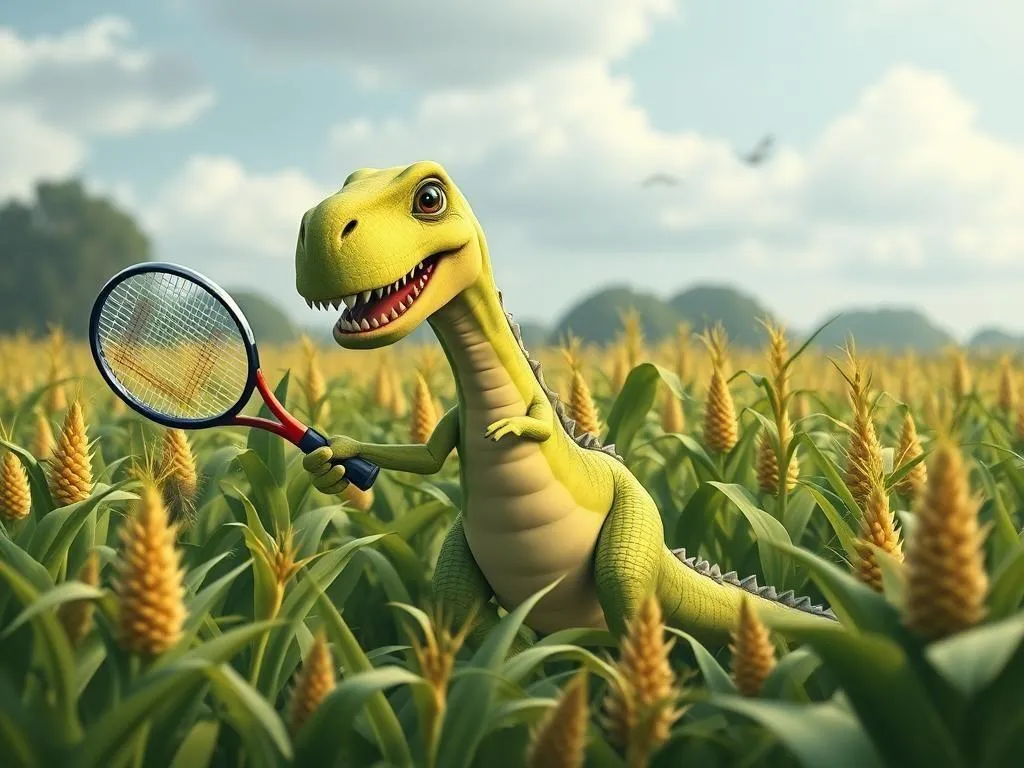

In [14]:
image_t.head()

### Learn More

To learn more about advanced techniques like RAG operations in Pixeltable, check out the [RAG Operations in Pixeltable](https://pixeltable.readme.io/docs/rag-operations-in-pixeltable) tutorial.

You can also look at how to work with images in Pixeltable: [Working with Images](https://pixeltable.readme.io/docs/working-with-images).

If you have any questions, don't hesitate to reach out.